# Titanic

Titanic was one of the largest and most opulent ships in the world.
It was also considered unsinkable, due to a series of compartment doors that could be closed if the bow was breached.
However, four days into its maiden voyage in 1912, the Titanic struck an iceberg, and less than three hours later it sank.

The objective of this notebook is to use machine learning to create a model that predicts which passengers were more likely to survive.
It was inspired by Kaggle competition **Titanic: Machine Learning from Disaster**.

The datasets are from https://www.kaggle.com/c/titanic/data.
train.csv contain the details of 891 passengers on board and reveal whether they survived or not.
The details are: Ticket class, Name, Sex, Age, Number of siblings/spouses aboard, Number of parents/children aboard, Ticket number, Fare, Cabin and Port of Embarkation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
plt.style.use("bmh")

In [2]:
# train data
train_data = pd.read_csv("train.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Variable Notes:

* survival:
  * 0 = No
  * 1 = Yes

* pclass: A proxy for socio-economic status (SES)
  * 1st = Upper
  * 2nd = Middle
  * 3rd = Lower

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way:
  * Sibling = brother, sister, stepbrother, stepsister
  * Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way:
  * Parent = mother, father
  * Child = daughter, son, stepdaughter, stepson
  * Some children travelled only with a nanny, therefore parch=0 for them.

* embarked: Port of Embarkation
  * C = Cherbourg
  * Q = Queenstown
  * S = Southampton


In [4]:
train_data.shape

(891, 12)

In [5]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
# check missing data
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# column Age has misisng values, let's fill those with mean age
train_data["Age"].fillna(train_data["Age"].mean(), inplace=True)

In [8]:
# column Cabin has many missing values and it doesn't seem that important so I'll drop it
train_data.drop(["Cabin"], axis=1, inplace=True)

In [9]:
# I will also drop the 2 rows that have missing values in Embarked
train_data.dropna(axis=0, how="any", subset=["Embarked"], inplace=True)

In [10]:
# check if everything went like I wanted
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [11]:
# Name and Ticket doesn't contribute to passenger survival, I will drop them as well
train_data.drop(["Name", "Ticket"], axis=1, inplace=True)

In [12]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


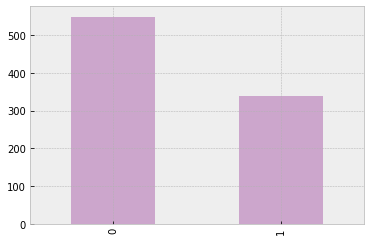

In [13]:
train_data["Survived"].value_counts().plot(kind="bar", color="purple", alpha=0.3)

60% of people survived and 40% didn't.

Let's see how each characteristic affects the survival rate.

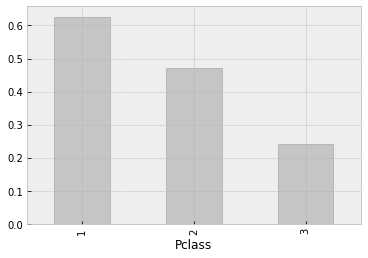

In [14]:
g1 = train_data.groupby("Pclass")["Survived"].mean()
g1.plot(kind="bar", alpha=0.3, ec="k", color="dimgrey")

The majority of the passengers from the first class survived while the majority of the passengers from the third class did not survived.

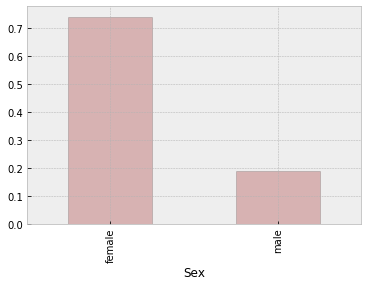

In [15]:
g2 = train_data.groupby("Sex")["Survived"].mean()
g2.plot(kind="bar", alpha=0.3, ec="k", color="brown")

Although the majority of men died, the majority of women survived.

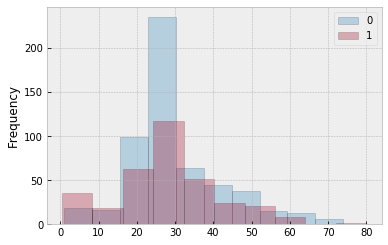

In [16]:
g3 = train_data.groupby("Survived")["Age"]
g3.plot(kind="hist", alpha=0.3, ec="k")
plt.legend()

Passengers of all ages survived and died.

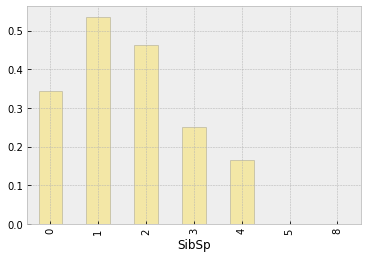

In [17]:
g4 = train_data.groupby("SibSp")["Survived"].mean()
g4.plot(kind="bar", alpha=0.3, ec="k", color="gold")

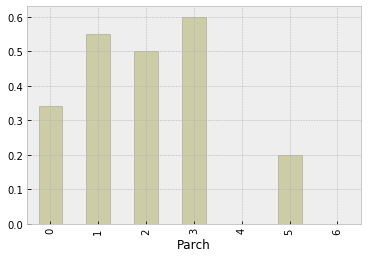

In [18]:
g5 = train_data.groupby("Parch")["Survived"].mean()
g5.plot(kind="bar", alpha=0.3, ec="k", color="olive")

Middle size families had higher survival rate than those who travelled alone or  with big families.

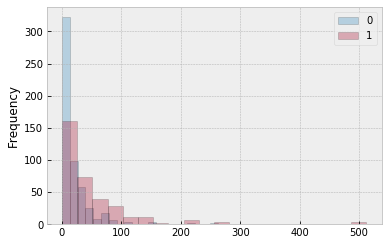

In [19]:
g6 = train_data.groupby("Survived")["Fare"]
g6.plot(kind="hist", bins=20, alpha=0.3, ec="k")
plt.legend()

People who paid less than 100 more likely died while the others more likely survived.

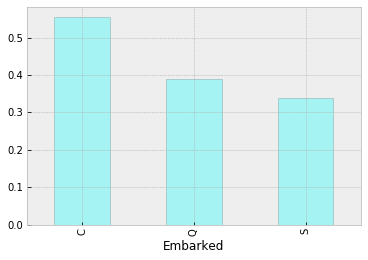

In [20]:
g7 = train_data.groupby("Embarked")["Survived"].mean()
g7.plot(kind="bar", alpha=0.3, ec="k", color="aqua")

The majority of the passengers from Cherbourg survived while the majority of the passengers from Southampton didn't.

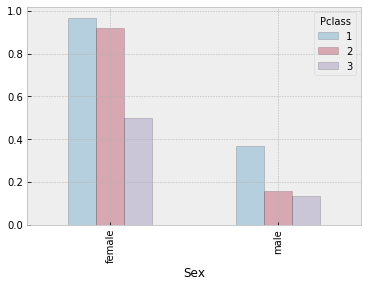

In [21]:
g8 = train_data.pivot_table("Survived", index="Sex", columns="Pclass")
g8.plot(kind="bar", alpha=0.3, ec="k")

Woman in first class had a great chance of survival and men in third class had a small chance of survival.

In [22]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

In [23]:
# Since Sex and Embarked columns aren't numerical values, I will transform them

print(train_data["Sex"].unique())
mappingsex = {"male": 0, "female": 1}
train_data["Sex"] = train_data["Sex"].map(mappingsex)
print(train_data["Sex"].unique())

print(train_data["Embarked"].unique())
mappingembarked = {"S": 0.0, "C": 0.5, "Q": 1.0}
train_data["Embarked"] = train_data["Embarked"].map(mappingembarked)
print(train_data["Embarked"].unique())

['male' 'female']
[0 1]
['S' 'C' 'Q']
[0.  0.5 1. ]


In [24]:
train_data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,0.350956,29.653446,0.524184,0.382452,32.096681,0.181102
std,256.998173,0.486260,0.834700,0.477538,12.968366,1.103705,0.806761,49.697504,0.318079
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,0.000000
50%,446.000000,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000
75%,668.000000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.500000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [25]:
# Now I will make all variables range from 0 to 1, because machine learning algorithms work better that way.

train_data["Pclass"] = train_data["Pclass"] / 3
train_data["Age"] = train_data["Age"] / 80
train_data["SibSp"] = train_data["SibSp"] / 8
train_data["Parch"] = train_data["Parch"] / 6
train_data["Fare"] = train_data["Fare"] / 512.329200

In [26]:
train_data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,0.770529,0.350956,0.370668,0.065523,0.063742,0.062649,0.181102
std,256.998173,0.486260,0.278233,0.477538,0.162105,0.137963,0.134460,0.097003,0.318079
min,1.000000,0.000000,0.333333,0.000000,0.005250,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,0.666667,0.000000,0.275000,0.000000,0.000000,0.015412,0.000000
50%,446.000000,0.000000,1.000000,0.000000,0.371239,0.000000,0.000000,0.028213,0.000000
75%,668.000000,1.000000,1.000000,1.000000,0.437500,0.125000,0.000000,0.060508,0.500000
max,891.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# Split data
train_data_X = train_data.drop("Survived", axis=1)
train_data_y = train_data["Survived"]

Since this is a supervised learning problem, I will try Linear Regression, Logistic Regression, SVC, KNeighborsClassifier, GaussianNB, DecisionTreeClassifier and RandomForestClassifier.

In [28]:
lrparam = {"fit_intercept": [True, False], "normalize": [True, False], "copy_X": [True, False]}
lrgrid = GridSearchCV(LinearRegression(), lrparam, cv=10)
lrgrid.fit(train_data_X, train_data_y)
print("Best Linear Regression score:", lrgrid.best_score_)
print("Best Linear Regression estimator:", lrgrid.best_estimator_)

Best Linear Regression score: 0.36035431926944383
Best Linear Regression estimator: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [29]:
logrparam = {"penalty": ["l1", "l2"], "solver": ["liblinear"], "C": np.linspace(0.00002, 1, 100)}
logrrand = RandomizedSearchCV(LogisticRegression(), logrparam, cv=5, n_iter=15, scoring="accuracy")
logrrand.fit(train_data_X, train_data_y)
print("Best Logistic Regression score:", logrrand.best_score_)
print("Best Logistic Regression estimator:", logrrand.best_estimator_)

Best Logistic Regression score: 0.7952897860724942
Best Logistic Regression estimator: LogisticRegression(C=0.5353628282828282, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [30]:
svcparam = {"C": [0.1, 1, 10, 100, 1000], "kernel": ["rbf", "linear", "poly", "sigmoid"]}
svcrand = RandomizedSearchCV(SVC(), svcparam, cv=5, n_iter=5, scoring="accuracy")
svcrand.fit(train_data_X, train_data_y)
print("Best SVC score:", svcrand.best_score_)
print("Best SVC estimator:", svcrand.best_estimator_)

Best SVC score: 0.7851520345331048
Best SVC estimator: SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [31]:
knnparam = {"n_neighbors": list(range(1, 31)), "weights": ["uniform", "distance"]}
knnrand = RandomizedSearchCV(KNeighborsClassifier(), knnparam, cv=5, scoring="accuracy", n_iter=15)
knnrand.fit(train_data_X, train_data_y)
print("Best KNeighborsClassifier score:", knnrand.best_score_)
print("Best KNeighborsClassifier estimator:", knnrand.best_estimator_)

Best KNeighborsClassifier score: 0.5074335047292579
Best KNeighborsClassifier estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')


In [32]:
gnbparam = {"var_smoothing": np.logspace(0, -9, num=100)}
gnbgrid = GridSearchCV(GaussianNB(), gnbparam, cv=10, scoring="accuracy")
gnbgrid.fit(train_data_X, train_data_y)
print("Best GaussianNB score:", gnbgrid.best_score_)
print("Best GaussianNB estimator:", gnbgrid.best_estimator_)

Best GaussianNB score: 0.7986338100102145
Best GaussianNB estimator: GaussianNB(priors=None, var_smoothing=4.328761281083053e-06)


In [33]:
dtparam = {"max_depth": [3, None], "max_features": randint(1, 9), "criterion": ["gini", "entropy"]}
dtrand = RandomizedSearchCV(DecisionTreeClassifier(), dtparam, cv=5, n_iter=15, scoring="accuracy")
dtrand.fit(train_data_X, train_data_y)
print("Best DecisionTreeClassifier score:", dtrand.best_score_)
print("Best DecisionTreeClassifier estimator:", dtrand.best_estimator_)

Best DecisionTreeClassifier score: 0.8177997841680951
Best DecisionTreeClassifier estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [34]:
rfparam = {"n_estimators": [int(x) for x in np.linspace(200, 2000, 10)], "max_features": ["log2", "sqrt", "auto"],
           "criterion": ["entropy", "gini"], "max_depth": [int(x) for x in np.linspace(10, 110, 11)],
           "min_samples_split": [2, 3, 5, 10], "min_samples_leaf": [1, 2, 4, 5, 8], "bootstrap": [True, False]}
rfrand = RandomizedSearchCV(RandomForestClassifier(), rfparam, cv=5, n_iter=15, scoring="accuracy")
rfrand.fit(train_data_X, train_data_y)
print("Best RandomForestClassifier score:", rfrand.best_score_)
print("Best RandomForestClassifier estimator:", rfrand.best_estimator_)

Best RandomForestClassifier score: 0.8256649527074208
Best RandomForestClassifier estimator: RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


The best estimator is RandomForestClassifier.

In [35]:
# test data
test_data = pd.read_csv("test.csv")

In [36]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [37]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [38]:
test_data["Age"].fillna(test_data["Age"].mean(), inplace=True)
test_data.drop(["Cabin"], axis=1, inplace=True)
test_data["Fare"].fillna(test_data["Fare"].mean(), inplace=True)

In [39]:
print(test_data.isnull().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [40]:
test_data.drop(["Name", "Ticket"], axis=1, inplace=True)
test_data["Sex"] = test_data["Sex"].map(mappingsex)
test_data["Embarked"] = test_data["Embarked"].map(mappingembarked)

In [41]:
test_data.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.363636,30.272590,0.447368,0.392344,35.627188,0.232057
std,120.810458,0.841838,0.481622,12.634534,0.896760,0.981429,55.840500,0.342758
min,892.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800,0.000000
50%,1100.500000,3.000000,0.000000,30.272590,0.000000,0.000000,14.454200,0.000000
75%,1204.750000,3.000000,1.000000,35.750000,1.000000,0.000000,31.500000,0.500000
max,1309.000000,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,1.000000


In [42]:
test_data["Pclass"] = test_data["Pclass"] / 3
test_data["Age"] = test_data["Age"] / 76
test_data["SibSp"] = test_data["SibSp"] / 8
test_data["Parch"] = test_data["Parch"] / 9
test_data["Fare"] = test_data["Fare"] / 512.329200

In [43]:
competitionprediction = rfrand.best_estimator_.predict(test_data)

In [44]:
output = pd.DataFrame({'PassengerId': test_data["PassengerId"], 'Survived': competitionprediction})
output.to_csv('my_submission.csv', index=False)

In [45]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# Reference

* https://www.britannica.com/topic/Titanic